First, we import the data

In [1]:
import json

data = json.load(open('wizard_of_wikipedia/data.json'))

## Dataset description

In [2]:
print('Each sample in the dataset has the following keys:')
for key in data[0].keys():
    print('-', key)

Each sample in the dataset has the following keys:
- chosen_topic
- persona
- wizard_eval
- dialog
- chosen_topic_passage


In [3]:
print('Each dialog object contains a list of utterances, \nwhere each utterance is a dictionary with the following keys:')
for key in data[0]['dialog'][0].keys():
    print('-', key)

Each dialog object contains a list of utterances, 
where each utterance is a dictionary with the following keys:
- speaker
- text
- checked_sentence
- checked_passage
- retrieved_passages
- retrieved_topics


In [4]:
print(f'The dataset contains {len(data)} documents.')

The dataset contains 22311 documents.


In [5]:
import nltk

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

dialogues = []

for document in data:
    dialogue = {}
    dialogue['topic'] = document['chosen_topic']
    dialogue['sentences_tokenized'] = []
    dialogue['starting_speaker'] = document['dialog'][0]['speaker']
    for utterance in document['dialog']:
        tokenized = tokenizer.tokenize(utterance['text'])
        # To lower case
        tokenized = [token.lower() for token in tokenized]
        dialogue['sentences_tokenized'].append(tokenized)
    dialogues.append(dialogue)

In [6]:
print('The "dialogues" object is a list of dictionaries, \nwhere each dictionary represents a dialogue and has the following keys:')
for key in dialogues[0].keys():
    print('-', key)
print('where "sentences_tokenized" is a list of lists, \nwhere each list represents a sentence and contains the tokens of that sentence.')

The "dialogues" object is a list of dictionaries, 
where each dictionary represents a dialogue and has the following keys:
- topic
- sentences_tokenized
- starting_speaker
where "sentences_tokenized" is a list of lists, 
where each list represents a sentence and contains the tokens of that sentence.


In [7]:
avg_doc_length = sum([len(dialogue['sentences_tokenized']) for dialogue in dialogues]) / len(dialogues)
print(f'The average document length is {avg_doc_length} sentences.')

The average document length is 9.053785128411993 sentences.


In [8]:
avg_sentence_length = sum([len(sentence) for dialogue in dialogues for sentence in dialogue['sentences_tokenized']]) / sum([len(dialogue['sentences_tokenized']) for dialogue in dialogues])
print(f'The average sentence length is {avg_sentence_length} tokens.')

The average sentence length is 16.73698879697424 tokens.


In [9]:
avg_vocabulary_size = sum([len(set([token for sentence in dialogue['sentences_tokenized'] for token in sentence])) for dialogue in dialogues]) / len(dialogues)
print(f'The average vocabulary size is {avg_vocabulary_size} tokens.')

The average vocabulary size is 93.67500336157053 tokens.


In [10]:
dataset_vocabulary_size = len(set([token for dialogue in dialogues for sentence in dialogue['sentences_tokenized'] for token in sentence]))
print(f'The dataset vocabulary size is {dataset_vocabulary_size} tokens.')

The dataset vocabulary size is 47189 tokens.


In [11]:
n_topics = len(set([dialogue['topic'] for dialogue in dialogues]))
print(f'The dataset contains {n_topics} topics.')

The dataset contains 1365 topics.


In [12]:
# Train a word2vec model
from gensim.models import Word2Vec

model = Word2Vec([sentence for dialogue in dialogues for sentence in dialogue['sentences_tokenized']], min_count=1, vector_size=100, workers=4)

In [13]:
# Get the vocabulary
vocabulary = list(model.wv.key_to_index.keys())

# Get the word embeddings
word_embeddings = model.wv[vocabulary]

# Get the word embedding for a specific word
print('The word embedding for the word "computer" is:')
print(model.wv['computer'])

The word embedding for the word "computer" is:
[-1.5243466   1.2864767   1.1018754  -0.12254961 -0.720656   -1.530709
 -0.63902557  1.1954211  -0.5474904  -1.3778303  -0.7752712  -0.55899113
  1.0701381   0.5652428   1.2042089   0.21594593 -0.51093435 -0.58081686
  1.0743582  -0.917596   -0.24127568 -0.7889623   0.8748849  -0.5951073
 -0.54961693 -0.13492069 -0.8184689  -0.62738085 -0.52644145 -0.7066269
 -0.69485825  0.62467325 -0.69377285  1.5614846   0.528939   -0.02529734
  0.8395333  -0.21236384  0.3500456   0.05917542  0.11988999  0.31521547
  0.06482221  0.36866745  0.23412073 -1.2222558  -0.97674143  0.00214019
  0.7329349  -0.410377    0.3308101   0.37831804 -0.3272228  -0.6724315
 -0.87370664  0.38296384  1.6781846  -0.3753948  -0.17446314  0.77174896
  1.1772242  -0.47085732 -0.5575017   0.15958445 -0.10403794 -1.277975
 -1.2341257  -0.17143315  0.2139332  -0.09612536 -0.46321625  0.06770409
  0.7207938  -0.13950546  0.500719    0.16609459  0.97575516 -0.3661185
 -0.4667212 

In [14]:
import numpy as np

def dialogue_embed(dialogue):
    dialogue_embedding = np.zeros(100)
    for sentence in dialogue['sentences_tokenized']:
        for token in sentence:
            dialogue_embedding += model.wv[token]
    dialogue_embedding /= sum([len(sentence) for sentence in dialogue['sentences_tokenized']])
    return dialogue_embedding

dialogue_embeddings = [dialogue_embed(dialogue) for dialogue in dialogues]

In [15]:
dialogue_embeddings = np.array(dialogue_embeddings)
dialogue_embeddings.shape

(22311, 100)

In [16]:
# Train a k-means clustering model
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_topics).fit(dialogue_embeddings)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_cluster(highlight, normal, dialogues, k, title):
    if highlight.shape[1] != normal.shape[1]:
        print('Error in the dimensions of the data. Shape of data must be coherent.')
    if highlight.shape[1] == 3:
        # Make a 3d plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(normal[:, 0], normal[:, 1], normal[:, 2], c='b', alpha=0.01)
        ax.scatter(highlight[:, 0], highlight[:, 1], highlight[:, 2], c='r', alpha=1)
    if highlight.shape[1] == 2:
        plt.figure(figsize=(10, 10))
        plt.scatter(normal[:, 0], normal[:, 1], c='b', alpha=0.05)
        plt.scatter(highlight[:, 0], highlight[:, 1], c='r', alpha=1)
    else:
        print('Error in the dimensions of the data. Shape must be 2 or 3.')
    plt.title(title)
    plt.show()
    print(nltk.Counter([dialogues[i]['topic'] for i in range(len(dialogues)) if cluster_labels[i] == k]))

In [70]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pca_2d = PCA(n_components=2)
# pca_2d.fit(dialogue_embeddings)
# dialogue_embeddings_2d = pca_2d.transform(dialogue_embeddings)

In [92]:
import pickle

# Dump
# pickle.dump(dialogue_embeddings_2d, open('dumps/clustering/pca_2d.pkl', 'wb'))

dialogue_embeddings_2d = pickle.load(open('dumps/clustering/pca_2d.pkl', 'rb'))

In [71]:
# pca_3d = PCA(n_components=3)
# pca_3d.fit(dialogue_embeddings)
# dialogue_embeddings_3d = pca_3d.transform(dialogue_embeddings)

In [94]:
# Dump
# pickle.dump(dialogue_embeddings_3d, open('dumps/clustering/pca_3d.pkl', 'wb'))

dialogue_embeddings_3d = pickle.load(open('dumps/clustering/pca_3d.pkl', 'rb'))

In [73]:
# tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)
# dialogue_embeddings_2d_tsne = tsne_2d.fit_transform(dialogue_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 22311 samples in 0.001s...
[t-SNE] Computed neighbors for 22311 samples in 0.747s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22311
[t-SNE] Computed conditional probabilities for sample 2000 / 22311
[t-SNE] Computed conditional probabilities for sample 3000 / 22311
[t-SNE] Computed conditional probabilities for sample 4000 / 22311
[t-SNE] Computed conditional probabilities for sample 5000 / 22311
[t-SNE] Computed conditional probabilities for sample 6000 / 22311
[t-SNE] Computed conditional probabilities for sample 7000 / 22311
[t-SNE] Computed conditional probabilities for sample 8000 / 22311
[t-SNE] Computed conditional probabilities for sample 9000 / 22311
[t-SNE] Computed conditional probabilities for sample 10000 / 22311
[t-SNE] Computed conditional probabilities for sample 11000 / 22311
[t-SNE] Computed conditional probabilities for sample 12000 / 22311
[t-SNE] Computed conditional probabilities for sam

In [96]:
# Dump
# pickle.dump(dialogue_embeddings_2d_tsne, open('dumps/clustering/tsne_2d.pkl', 'wb'))

dialogue_embeddings_2d_tsne = pickle.load(open('dumps/clustering/tsne_2d.pkl', 'rb'))

In [74]:
# tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, verbose=1)
# dialogue_embeddings_3d_tsne = tsne_3d.fit_transform(dialogue_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 22311 samples in 0.001s...
[t-SNE] Computed neighbors for 22311 samples in 0.781s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22311
[t-SNE] Computed conditional probabilities for sample 2000 / 22311
[t-SNE] Computed conditional probabilities for sample 3000 / 22311
[t-SNE] Computed conditional probabilities for sample 4000 / 22311
[t-SNE] Computed conditional probabilities for sample 5000 / 22311
[t-SNE] Computed conditional probabilities for sample 6000 / 22311
[t-SNE] Computed conditional probabilities for sample 7000 / 22311
[t-SNE] Computed conditional probabilities for sample 8000 / 22311
[t-SNE] Computed conditional probabilities for sample 9000 / 22311
[t-SNE] Computed conditional probabilities for sample 10000 / 22311
[t-SNE] Computed conditional probabilities for sample 11000 / 22311
[t-SNE] Computed conditional probabilities for sample 12000 / 22311
[t-SNE] Computed conditional probabilities for sam

In [98]:
# Dump
# pickle.dump(dialogue_embeddings_3d_tsne, open('dumps/clustering/tsne_3d.pkl', 'wb'))

dialogue_embeddings_3d_tsne = pickle.load(open('dumps/clustering/tsne_3d.pkl', 'rb'))

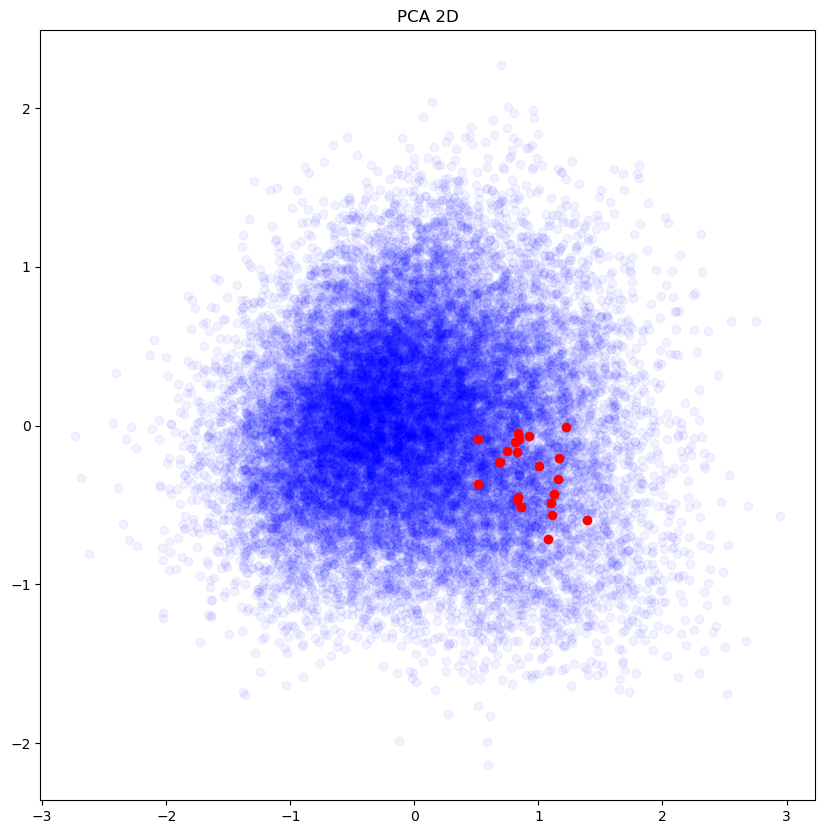

Counter({'Ford Mustang': 3, 'Ford Motor Company': 3, 'Chevrolet Corvette': 3, 'Ferrari': 3, 'Toyota': 2, 'Honda Civic': 2, 'BMW': 1, 'Nintendo': 1, 'Toyota Prius': 1, 'Ford F-Series': 1, 'Jaguar': 1, 'Honda': 1})
Error in the dimensions of the data. Shape must be 2 or 3.


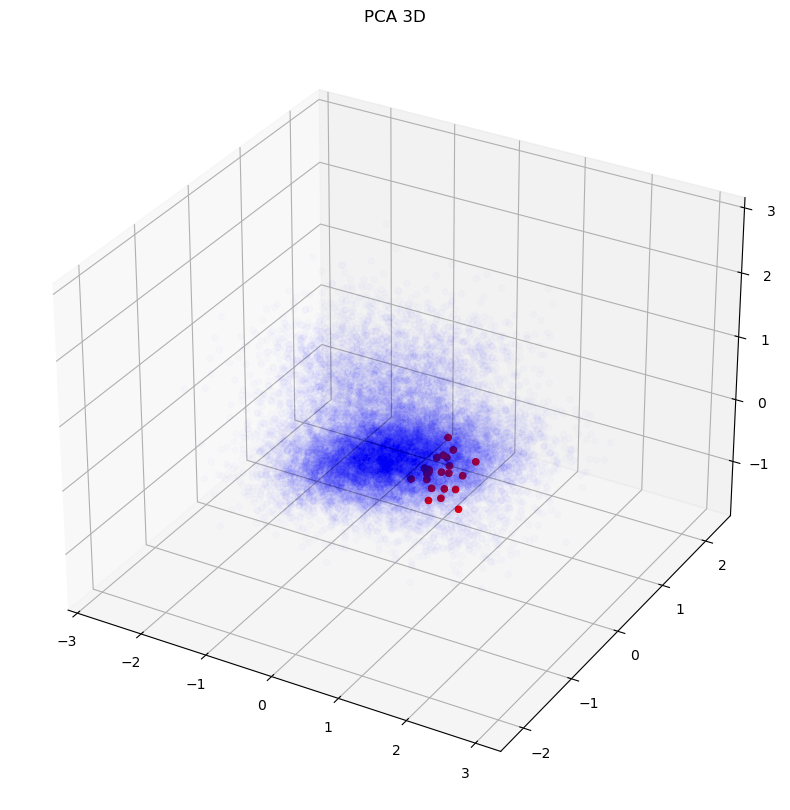

Counter({'Ford Mustang': 3, 'Ford Motor Company': 3, 'Chevrolet Corvette': 3, 'Ferrari': 3, 'Toyota': 2, 'Honda Civic': 2, 'BMW': 1, 'Nintendo': 1, 'Toyota Prius': 1, 'Ford F-Series': 1, 'Jaguar': 1, 'Honda': 1})


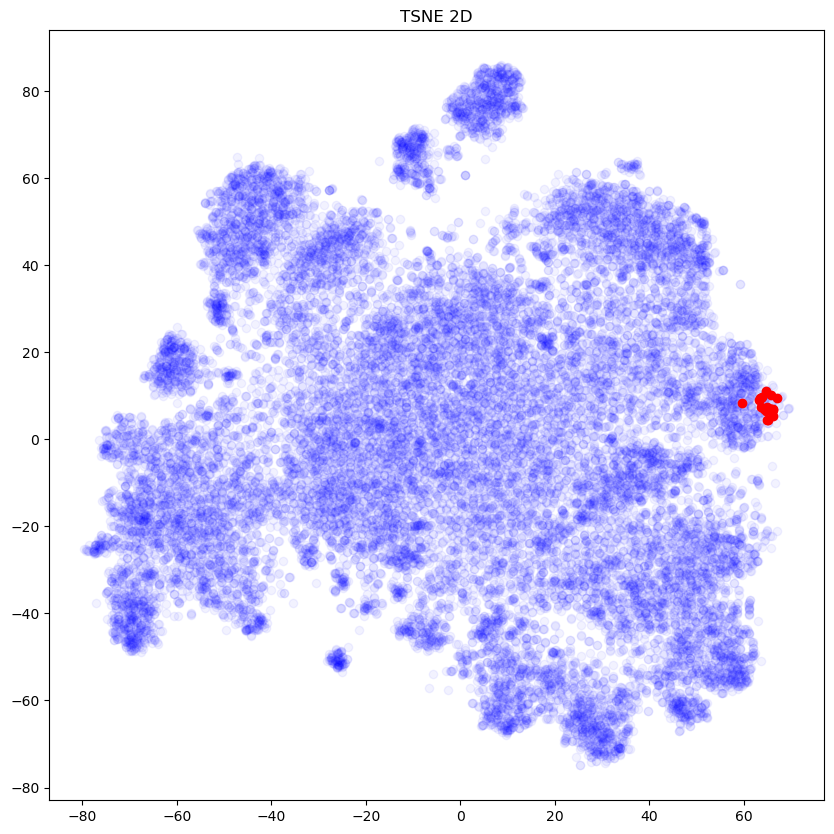

Counter({'Ford Mustang': 3, 'Ford Motor Company': 3, 'Chevrolet Corvette': 3, 'Ferrari': 3, 'Toyota': 2, 'Honda Civic': 2, 'BMW': 1, 'Nintendo': 1, 'Toyota Prius': 1, 'Ford F-Series': 1, 'Jaguar': 1, 'Honda': 1})
Error in the dimensions of the data. Shape must be 2 or 3.


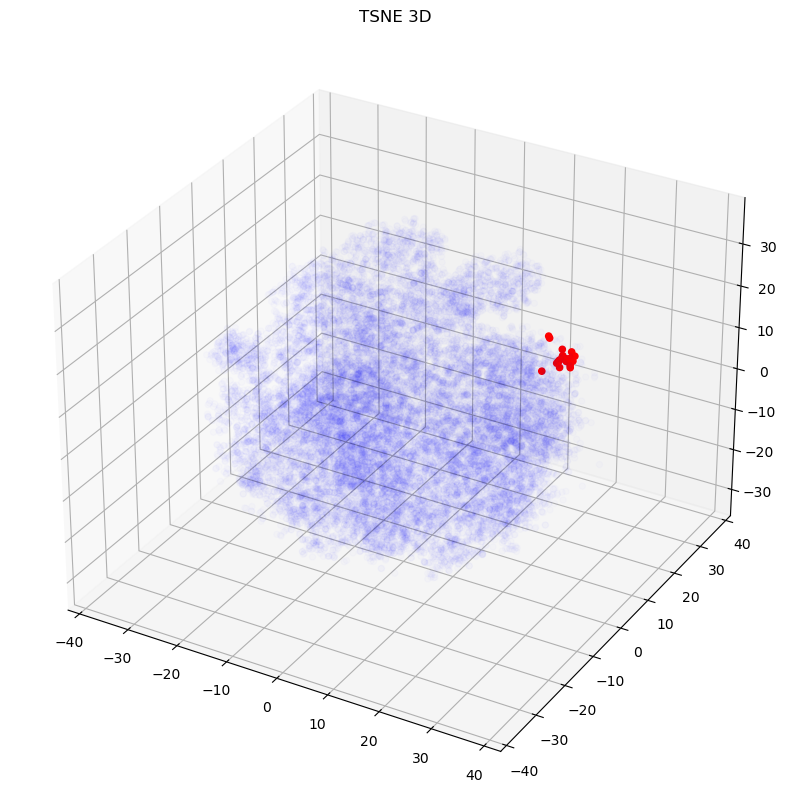

Counter({'Ford Mustang': 3, 'Ford Motor Company': 3, 'Chevrolet Corvette': 3, 'Ferrari': 3, 'Toyota': 2, 'Honda Civic': 2, 'BMW': 1, 'Nintendo': 1, 'Toyota Prius': 1, 'Ford F-Series': 1, 'Jaguar': 1, 'Honda': 1})


In [100]:
k = 375

visualize_cluster(dialogue_embeddings_2d[cluster_labels == k], dialogue_embeddings_2d[cluster_labels != k], dialogues, k, 'PCA 2D')
visualize_cluster(dialogue_embeddings_3d[cluster_labels == k], dialogue_embeddings_3d[cluster_labels != k], dialogues, k, 'PCA 3D')
visualize_cluster(dialogue_embeddings_2d_tsne[cluster_labels == k], dialogue_embeddings_2d_tsne[cluster_labels != k], dialogues, k, 'TSNE 2D')
visualize_cluster(dialogue_embeddings_3d_tsne[cluster_labels == k], dialogue_embeddings_3d_tsne[cluster_labels != k], dialogues, k, 'TSNE 3D')